In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pip uninstall tensorflow

Uninstalling tensorflow-2.2.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0


In [3]:
pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 20kB/s 
     |████████████████████████████████| 3.9MB 44.7MB/s 
     |████████████████████████████████| 450kB 46.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=e07f0bc06f678e7a5d3e811c15d895604331a0132a8271537b61a399cb298a0e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0


In [4]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

2.1.0
/device:GPU:0


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

class FireDetectionNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# CONV => RELU => POOL
		model.add(SeparableConv2D(16, (7, 7), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # CONV => RELU => POOL
		model.add(SeparableConv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# (CONV => RELU) * 2 => POOL
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# second set of FC => RELU layers
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [6]:
FIRE_PATH = '/content/drive/My Drive/Colab Notebooks/Fireset'
NON_FIRE_PATH = '/content/drive/My Drive/spatial_envelope_256x256_static_8outdoorcategories'

In [22]:
# initialize the class labels in the dataset
CLASSES = ["Non-Fire", "Fire"]

# define the size of the training and testing split
TRAIN_SPLIT = 0.80
TEST_SPLIT = 0.20

# define the initial learning rate, batch size, and number of epochs
INIT_LR = 1e-2
BATCH_SIZE = 64
NUM_EPOCHS = 60

# set the path to the serialized model after training
####MODEL_PATH = os.path.sep.join(["output", "fire_detection.model"])

# define the path to the output learning rate finder plot and
# training history plot
####LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot.png"])
####TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])

# define the path to the output directory that will store our final
# output with labels/annotations along with the number of iamges to
# sample
####OUTPUT_IMAGE_PATH = os.path.sep.join(["output", "examples"])
SAMPLE_SIZE = 50

In [8]:
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

def load_dataset(datasetPath):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images
	imagePaths = list(paths.list_images(datasetPath))
	data = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image and resize it to be a fixed 128x128 pixels,
		# ignoring aspect ratio
		image = cv2.imread(imagePath)
		image = cv2.resize(image, (128, 128))

		# add the image to the data lists
		data.append(image)
  # return the data list as a NumPy array
	return np.array(data, dtype="float32")

# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-f", "--lr-find", type=int, default=0,
#	help="whether or not to find optimal learning rate")
#args = vars(ap.parse_args())

# load the fire and non-fire images
print("[INFO] loading data...")
fireData = load_dataset( FIRE_PATH)
nonFireData = load_dataset( NON_FIRE_PATH)
print("[INFO] Completed")

[INFO] loading data...
[INFO] Completed


In [9]:
print(fireData.shape)
print(nonFireData.shape)

(2236, 128, 128, 3)
(2693, 128, 128, 3)


In [10]:
fireLabels = np.ones((fireData.shape[0],))
nonFireLabels = np.zeros((nonFireData.shape[0],))
# stack the fire data with the non-fire data, then scale the data
# to the range [0, 1]
data = np.vstack([fireData, nonFireData])
labels = np.hstack([fireLabels, nonFireLabels])

In [11]:
data /= 255
# perform one-hot encoding on the labels and account for skew in the
# labeled data
labels = to_categorical(labels, num_classes=2)
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [12]:
print(data.shape)
print(labels.shape)
print(labels[1:])
print(classTotals)

(4929, 128, 128, 3)
(4929, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[2693. 2236.]


In [13]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size= TEST_SPLIT, random_state=42)

In [14]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(3943, 128, 128, 3)
(3943, 2)
(986, 128, 128, 3)
(986, 2)


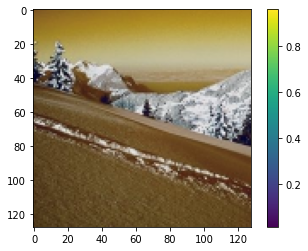

In [15]:
%matplotlib inline
plt.figure()
plt.imshow(trainX[65])
plt.colorbar()
plt.grid(False)
plt.show()

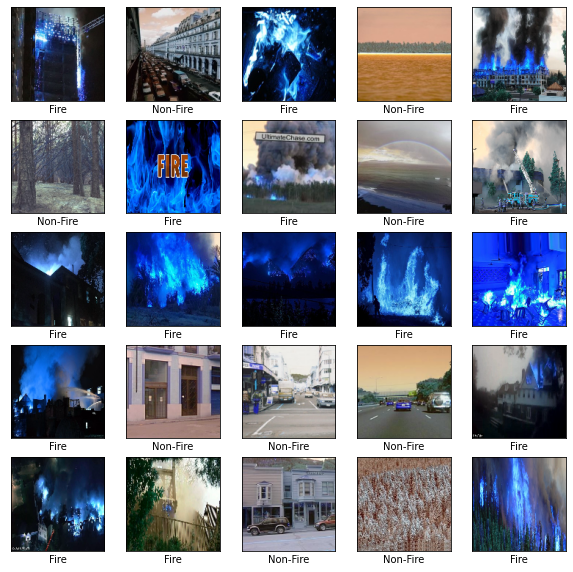

In [16]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i], cmap=plt.cm.binary)
    if trainY[i][0] == 1:
      plt.xlabel("Non-Fire")
    else:
      plt.xlabel("Fire")

plt.show()

In [26]:
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr= INIT_LR, momentum=0.9,
	decay= INIT_LR /  NUM_EPOCHS)
model = FireDetectionNet.build(width=128, height=128, depth=3,
	classes=2)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# check to see if we are attempting to find an optimal learning rate
# before training for the full number of epochs

# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size= BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] //  BATCH_SIZE,
	epochs= NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)

# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size= BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
predictions.argmax(axis=1), target_names= CLASSES))

# serialize the model to disk
#print("[INFO] serializing network to '{}'...".format( MODEL_PATH))
#model.save( MODEL_PATH)

[INFO] compiling model...
[INFO] training network...
  ...
    to  
  ['...']
Train for 61 steps, validate on 986 samples
Epoch 1/60
61/61 [==============================] - 16s 269ms/step - loss: 0.5794 - accuracy: 0.7363 - val_loss: 0.7339 - val_accuracy: 0.4726
Epoch 2/60
61/61 [==============================] - 15s 250ms/step - loss: 0.4417 - accuracy: 0.7984 - val_loss: 0.5979 - val_accuracy: 0.6237
Epoch 3/60
61/61 [==============================] - 16s 254ms/step - loss: 0.4023 - accuracy: 0.8175 - val_loss: 0.5005 - val_accuracy: 0.8225
Epoch 4/60
61/61 [==============================] - 15s 252ms/step - loss: 0.3728 - accuracy: 0.8337 - val_loss: 0.4104 - val_accuracy: 0.8134
Epoch 5/60
61/61 [==============================] - 15s 251ms/step - loss: 0.3643 - accuracy: 0.8373 - val_loss: 0.3176 - val_accuracy: 0.8854
Epoch 6/60
61/61 [==============================] - 15s 251ms/step - loss: 0.3454 - accuracy: 0.8484 - val_loss: 0.3606 - val_accuracy: 0.8408
Epoch 7/60
61/61 [==

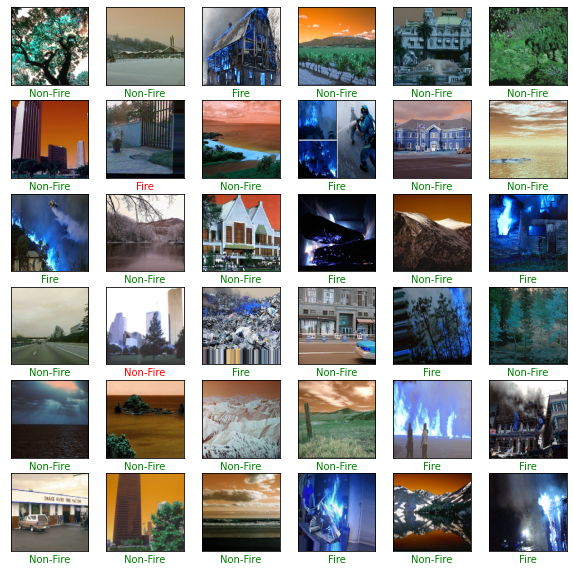

In [28]:
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testX[i], cmap=plt.cm.binary)
    if testY[i][0] == 1:
      if predictions[i][0] > 0.5:
        plt.xlabel("Non-Fire", color='green')
      else:
        plt.xlabel("Non-Fire", color='red')
    else:
      if predictions[i][1] > 0.5:
        plt.xlabel("Fire", color='green')
      else:
        plt.xlabel("Fire", color='red')

plt.show()

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_38 (Separab (None, 128, 128, 16)      211       
_________________________________________________________________
activation_65 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
separable_conv2d_39 (Separab (None, 64, 64, 32)        688       
_________________________________________________________________
activation_66 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 64, 64, 32)       